# Pokémon showdown
## Domain understanding
Pokémon is the highest-grossing media franchise worldwide of all time. The games even have a pretty big online competitive player vs player battle simulator. This simulator is called Pokémon showdown. It is a website where you can play Pokémon games online against other players. I have been a long time fan of the Pokémon series and after playing their most recent game title I wanted to learn how to play competitive Pokémon. When I wanted to play the official format I hit a big wall, team building. Constructing a good team is the base to win a game of competitive Pokémon in Pokémon showdown, there are a lot of things to keep count of when constructing a team such as; type matchups, strategies, items your Pokémon are holding and stat parameters that effect the power of your Pokémon. This was a big hurdle for me to start playing Pokémon showdown. When I needed a challenge for this school project I instantly thought of the struggle I faced when wanting to play Pokémon showdown. I wondered what Pokémon are the most popular and what Pokémon are the most used. I have also wondered what the most popular Pokémon are in different generations. Every few years a new generation of Pokémon comes out and there are around 100 to 200 new Pokémon added that are usable in competitive Pokémon. I want to find out if there is a way to predict which Pokémon will be used a lot for future generations.

## Data source

The data I am using is a usage file from Smogon. Smogon is a website that provides a lot of information about the Pokémon games. They have a lot of data about the games and the competitive scene. They also have a website where you can play Pokémon games online against other players. This is where the data I am using for the usage stats comes from. I wanted to combine the usage stats from Smogon with another dataset that contains all Pokémon and their various forms. This dataset is from Kaggle and is called ['Complete Pokémon Dataset (Gen I-VI)'](https://www.kaggle.com/datasets/brdata/complete-pokemon-dataset-gen-iiv). This dataset contains all Pokémon and their various forms.

## Pre-processing
To start off I needed a way to read out the data files that contain usage stats provided by Smogon*. As a base I used a script made by Kaggle user named 'Fruity Fritz'. I needed to reform a bit of their code to fit my own wants and needs.

*Smogon is a website that provides a lot of information about the Pokémon games. They have a lot of data about the games and the competitive scene. They also have a website where you can play Pokémon games online against other players. This is where the data I am using comes from.

In [475]:
import numpy as np
import pandas as pd
import urllib.request as urllib, os
import ssl

In [476]:
# made function to format the same sort of file later
def import_showdown_usage_stats(url, filename): # file url and name for local storage
    # location for datafile
    datafolder = 'data/'
    #download file from url to local storage
    gcontext = ssl.SSLContext() # needed to avoid possible certificate validation error
    downloaded = urllib.urlopen(url, context=gcontext)
    buf = downloaded.read()

    try:
        os.mkdir(datafolder)
    except FileExistsError:
        pass

    with open(datafolder + filename, 'wb') as f:
        f.write(buf)
    # import dataframe
    df = pd.read_csv(datafolder + filename, sep="|",skiprows=5,names=["rank","pokemon","usage","count",],usecols=[1,2,3,4])
    # drop any NaNs we find
    df.dropna(inplace=True)
    # changing data type of the columns
    for k, v in {"rank":int,"pokemon":str, "usage":str, "count":int}.items():
        df[k] = df[k].astype(v)
    # fixing leading/trailing white spaces
    df["pokemon"] = df["pokemon"].str.strip()
    df["usage"] = df["usage"].str.strip()
    # fixing format of string to not use '%'
    df["usage"] = df["usage"].str.rstrip('%')
    # change datatype of usage_%
    df["usage"] = df["usage"].astype(float) / 100
    # get rid of unnecessary columns
    df = df[['pokemon' ,'count' ,'usage']]
    return df

Now we need to use the method above to import and format a usage file from Smogon.

In [477]:
usage_stats = import_showdown_usage_stats(url = "https://www.smogon.com/stats/2023-01/gen9vgc2023series2-0.txt", filename="gen9s2vgc0.txt")
print(usage_stats.shape)
usage_stats

(393, 3)


,pokemon,count,usage
0,Flutter Mane,795029,2.804525e-01
1,Iron Hands,724440,2.555517e-01
2,Amoonguss,705360,2.488211e-01
3,Iron Bundle,663073,2.339040e-01
4,Gholdengo,635767,2.242716e-01
...,...,...,...
388,Smoliv,1,4.000000e-07
389,Bounsweet,1,4.000000e-07
390,Staravia,1,4.000000e-07
391,Nacli,1,4.000000e-07


I imported the dataset containing all Pokémon as a csv file and found out the encoding was not the standard UTF-8 encoding, so I just needed to specify the encoding in the read function.

In [478]:
names = ["dexnum","name","type1","type2","total","hp","atk","def","sp.atk","sp.def","spd","variant"]
stats = pd.read_csv("./data/Pokedex_Cleaned.csv",names=names,encoding='windows-1252')
print(stats.shape)
stats.head(10)

(1173, 12)


,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,NaN
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,NaN
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,NaN
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,NaN
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,NaN
6,6,Charizard,Fire,Dragon,634,78,130,111,130,85,100,Mega X
7,6,Charizard,Fire,Flying,634,78,104,78,159,115,100,Mega Y
8,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,NaN
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,NaN


## Data cleaning

There were a lot of NaN values which I needed to fill in a way so that the data is 'complete' and ready to be merged with the usage dataset from Smogon.

In [479]:
stats.type2 = stats.type2.fillna('none') # if the second typing is NaN it means there is no second typing hence the value of none
stats.variant = stats.variant.fillna('') # if the variant is NaN it means there is no variant. replaced with empty string to add variant at the end of the name as done in the usage df
stats.head(10)

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,
4,4,Charmander,Fire,none,309,39,52,43,60,50,65,
5,5,Charmeleon,Fire,none,405,58,64,58,80,65,80,
6,6,Charizard,Fire,Dragon,634,78,130,111,130,85,100,Mega X
7,6,Charizard,Fire,Flying,634,78,104,78,159,115,100,Mega Y
8,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,
9,7,Squirtle,Water,none,314,44,48,65,50,64,43,


After seeing the datafile above I wanted to check the values of both the type columns.

First I wanted to check the type2 column, so I can see if the previous action to fill the NaN values actually worked.

In [480]:
stats.type2.value_counts()

none        540
Flying      118
Psychic      47
Poison       46
Fairy        42
Fighting     42
Ground       41
Steel        38
Dragon       35
Ghost        34
Grass        34
Dark         33
Water        22
Ice          22
Fire         19
Rock         19
Normal       19
Electric     13
Bug           9
Name: type2, dtype: int64

These values are what I expected and also what I want from this column

When inspecting the datafile in another software tool, I found that there were some wierd values in type1 and  wanted to check them out.

In [481]:
stats.type1.value_counts()

Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Electric     73
Fire         73
Rock         67
Dark         56
Dragon       47
Ground       47
Poison       46
Fighting     46
Ghost        46
Steel        42
Fairy        32
Ice          27
Flying       12
Null          2
Male          1
Female        1
Rockruff      1
Name: type1, dtype: int64

After seeing the wierd values of Rockruff, null, male and female in typings I further looked into them.

In [482]:
stats.loc[(stats['type1'] == "Rockruff") | (stats['type1'] == "Male") | (stats['type1'] == "Female") | (stats['type1'] == "Null")]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
801,678,Meowstic,Male,Psychic,466,74,48,76,83,81,104,
802,678,Meowstic,Female,Psychic,466,74,48,76,83,81,104,
884,744,Rockruff,Rockruff,Rock,280,45,65,40,30,40,60,Own Tempo
916,772,Type:,Null,Normal,534,95,95,95,95,95,59,
917,772,Type:,Null,none,534,95,95,95,95,95,59,


The null value is from a Pokémon named "type:null", both records are for this same Pokémon. The stats are exactly the same, so I will delete the second mention and just replace the faulty record with a correct one.

The values for male and female are faulty in the sense that they occupy the wrong column, they need to be in variant but are in type1. The Rockruff record is also faulty. the Variant value contains their 'ability' which is another attribute that we do not need in this dataset. I have no idea why it is here.

Because there are only 5 faulty records, I am going to manually replace them.

In [483]:
stats.loc[801] = ['678','Meowstic','Psychic','none','466','74','48','76','83','71','104','Male']
stats.loc[802] = ['678','Meowstic','Psychic','none','466','74','48','76','83','71','104','Female']
stats.loc[884] = ['744','Rockruff','Rock','none','280','45','65','40','30','40','60','']
stats.loc[916] = ['772','Type:Null','Normal','none','534','95','95','95','95','95','59','']
stats.drop(stats.index[917], inplace=True)

stats.type1.value_counts()

Water       147
Normal      131
Grass       102
Bug          99
Psychic      78
Fire         73
Electric     73
Rock         68
Dark         56
Ground       47
Dragon       47
Fighting     46
Poison       46
Ghost        46
Steel        42
Fairy        32
Ice          27
Flying       12
Name: type1, dtype: int64

Later in the process of cleaning the data I found another faulty record. These were the records for the Pokémon named Nidoran. In the games this Pokémon has multiple variants and their gender is displayed next to their name to indicate which variant it is.

In [484]:
stats.loc[(stats['name'] == "Nidoran?")]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
40,29,Nidoran?,Poison,none,275,55,47,52,40,40,41,
43,32,Nidoran?,Poison,none,273,46,57,40,40,40,50,


In [485]:
stats.loc[40] = ['29','Nidoran','Poison','none','275','55','47','52','40','40','41','Female']
stats.loc[43] = ['32','Nidoran','Poison','none','273','46','57','40','40','40','50','Male']
stats.loc[(stats['name'] == "Nidoran")]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
40,29,Nidoran,Poison,none,275,55,47,52,40,40,41,Female
43,32,Nidoran,Poison,none,273,46,57,40,40,40,50,Male


Further, in my data cleaning process I found more faulty records. Some records have Ice suffixed to their name when it is meant to be in the Type1 column values and the Type1 column is supposed to be the type2 column values.

In [486]:
stats[stats['name'].str.contains("Ice")==True]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
184,144,ArticunoIce,Flying,none,580,90,85,100,95,125,85,
272,220,SwinubIce,Ground,none,250,50,50,40,30,30,50,
273,221,PiloswineIce,Ground,none,450,100,100,80,60,60,50,
278,225,DelibirdIce,Flying,none,330,45,55,45,65,45,75,
292,238,SmoochumIce,Psychic,none,305,45,30,15,85,65,65,
455,378,RegiceIce,Ice,none,580,80,50,100,100,200,50,
568,473,MamoswineIce,Ground,none,530,110,130,80,70,60,80,
574,478,FroslassIce,Ghost,none,480,70,80,70,80,70,110,
1022,872,SnomIce,Bug,none,185,30,25,35,45,30,20,
1023,873,FrosmothIce,Bug,none,475,70,65,60,125,90,65,


In [487]:
stats.loc[(stats['name'].str.contains("Ice")==True), 'type2'] = stats['type1']
stats.loc[(stats['name'].str.contains("Ice")==True), 'type1'] = 'Ice'
stats.loc[(stats['name'].str.contains("Ice")==True), 'name'] = stats['name'].str.replace('Ice','')
stats.loc[(stats['name'].str.contains("Froslass")==True)]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
574,478,Froslass,Ice,Ghost,480,70,80,70,80,70,110,


In [488]:
stats.loc[(stats['name'].str.contains("Regice")==True), 'type2'] = 'none'

After merging datasets I found some faulty names, there was really no correlation between these faulty records, so I am just going to replace fix up these records.

In [489]:
stats['name'] = stats['name'].replace('Flabébé','Flabebe') #had issues merging the records because of the e's

# the pokemon names Scatterbug had its name sliced between the name and type1 column. its type is indeed bug so I just renamed it and removed the second typing
stats.loc[(stats['name'].str.contains("Scatter")==True), 'name'] = stats['name'].str.replace('Scatter','Scatterbug')
stats.loc[(stats['name'].str.contains("Ice")==True), 'type2'] = 'none'



As you can see, the weird values are now no longer present in the dataset.

Now we are going to change the notation of the Variant to those that are used by our usage stats dataframe. These notations are the ones that Smogon uses.
When I found this dataset I knew it would take a lot of work to get all the data cleaned. I still chose this one because it was the most complete I could find. Even tough this dataset takes a lot of work to prepare, it only needs data cleaning, other datasets would need to be merged together to create this one and I prefer to clean just one dataset apposed to multiple.

The first thing we are going to do is remove all mega's from the list of Pokémon. This is because mega is a mechanic and not a Pokémon to choose for your team.

In [490]:
stats = stats[stats.variant != 'Mega']
stats = stats[stats.variant != 'Mega X']
stats = stats[stats.variant != 'Mega Y']
stats.variant.value_counts()

                    979
Galarian             16
Alolan               15
Hisuian              13
Therian Form          4
                   ... 
Confined              1
Unbound               1
Baile Style           1
Pa u Style            1
Two-Segment Form      1
Name: variant, Length: 85, dtype: int64

After this I needed to clean the remaining variants. To start with I changed the notation of the regions to the one that Smogon uses.

In [491]:
stats['variant'] = stats['variant'].str.strip()
# notation for region specific variants
stats['variant'] = stats['variant'].replace(['Galarian'],'Galar')
stats['variant'] = stats['variant'].replace(['Alolan'],'Alola')
stats['variant'] = stats['variant'].replace(['Hisuian'],'Hisui')
stats['variant'] = stats['variant'].replace(['Paldean'],'Paldea')

Then I changed the gender notations.

In [492]:
# gender notation
stats['variant'] = stats['variant'].replace(['Female'],'F')
stats['variant'] = stats['variant'].replace(['Male'],'')

Then I removed the suffixes(?).

In [493]:
# removed unneeded endings
stats['variant'] = stats['variant'].str.replace(' Form','')
stats['variant'] = stats['variant'].str.replace(' Style','')
stats['variant'] = stats['variant'].str.replace(' Super','')
stats['variant'] = stats['variant'].str.replace(' Size','')
stats['variant'] = stats['variant'].str.replace(' Plumage','')

After that I removed records of variant that do not change the stats of the Pokémon.

In [494]:
# variants that dont matter in stats or are not available in Pokemon showdown
stats = stats[stats.variant != 'Blue-Striped']
stats = stats[stats.variant != 'Red-Striped']
stats = stats[stats.variant != 'Partner']
stats = stats[stats.variant != 'Altered']
stats = stats[stats.variant != 'Eternamax']

There were still some Pokémon with multiple variants that did not have a base variant or empty variant. Those still needed fixing.

In [495]:
# base forms that have a variant fixes
stats['variant'] = stats['variant'].replace('White-Striped','')
stats['variant'] = stats['variant'].replace('Hero of Many Battles','')
stats['variant'] = stats['variant'].replace('Incarnate','')
stats['variant'] = stats['variant'].replace('Ordinary','')
stats['variant'] = stats['variant'].replace('Aria','')
stats['variant'] = stats['variant'].replace('Shield','')
stats['variant'] = stats['variant'].replace('Average','')
stats['variant'] = stats['variant'].replace('50%','')
stats['variant'] = stats['variant'].replace('Confined','')
stats['variant'] = stats['variant'].replace('Baile','')
stats['variant'] = stats['variant'].replace('Midday','')
stats['variant'] = stats['variant'].replace('Solo','')
stats['variant'] = stats['variant'].replace('Core','')
stats['variant'] = stats['variant'].replace('Single Strike','')
stats['variant'] = stats['variant'].replace('Full Belly Mode','')
stats['variant'] = stats['variant'].replace('Family of Three','')
stats['variant'] = stats['variant'].replace('Family of Four','')
stats['variant'] = stats['variant'].replace('Amped','')
stats['variant'] = stats['variant'].replace('Two-Segment','')
stats['variant'] = stats['variant'].replace('Green','')
stats['variant'] = stats['variant'].replace('Zero','')

Now I needed to manually fix the variants that still needed fixes.

In [496]:
# unique variant notation fixes
stats['variant'] = stats['variant'].replace('Crowned Sword','Crowned')
stats['variant'] = stats['variant'].replace('Crowned Shield','Crowned')
stats['variant'] = stats['variant'].replace('Ice Rider','Ice')
stats['variant'] = stats['variant'].replace('Shadow Rider','Shadow')
stats['variant'] = stats['variant'].replace('Galarian Zen','Galar-Zen')
stats['variant'] = stats['variant'].replace('Pa u',"Pa'u")
stats['variant'] = stats['variant'].replace('Rapid Strike','Rapid-Strike')
stats['variant'] = stats['variant'].replace('Hangry Mode','Hangry')
stats['variant'] = stats['variant'].replace('Low Key','Low-Key')
stats['variant'] = stats['variant'].replace('Galarian Standard','Galar')

stats.variant.value_counts()

                 1009
Galar              17
Alola              15
Hisui              13
Therian             4
F                   4
Origin              3
Super               2
Small               2
Primal              2
White               2
Sandy Cloak         2
Trash Cloak         2
Large               2
Crowned             2
Plant Cloak         2
Dusk                1
Midnight            1
School              1
Meteor              1
Dawn Wings          1
Hangry              1
Dusk Mane           1
Ultra               1
Low-Key             1
Pom-Pom             1
Rapid-Strike        1
Ice                 1
Shadow              1
Blue                1
Yellow              1
Hero                1
Sensu               1
Blade               1
Pa'u                1
Mow                 1
Paldea              1
Rainy               1
Snowy               1
Sunny               1
Fan                 1
Frost               1
Heat                1
Wash                1
Unbound             1
Galar-Zen 

After this there were still 6 variants that were not yet fully clean. These were the Pokémon: Burmy and Wormadam. These two Pokémon have the same shared 3 Variants, but those variants only matter for Wormadam and not for Burmy. This means I will need to manually these values. the Variants in question are the Plant Cloak, Sandy Cloak and Trash Cloak variants. The Plant cloak is the easiest to handle because this is the 'default' form according to the [Smogon Pokédex](https://www.smogon.com/dex/sv/pokemon/), this means that an empty('') value would be fitting for both Pokémon. The naming of cloak in the variant needs to be removed for the same reason.
 The only thing left to do was to remove the remaining Burmy, the way I found easiest was to locate them and manually remove the unneeded records.

In [497]:
stats['variant'] = stats['variant'].replace('Plant Cloak','')
stats['variant'] = stats['variant'].str.replace(' Cloak','')
stats.loc[(stats['name'] == "Burmy") | (stats['name'] == "Wormadam")]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
493,412,Burmy,Bug,none,224,40,29,45,29,45,36,
494,412,Burmy,Bug,none,224,40,29,45,29,45,36,Sandy
495,412,Burmy,Bug,none,224,40,29,45,29,45,36,Trash
499,413,Wormadam,Bug,Grass,424,60,59,85,79,105,36,
500,413,Wormadam,Bug,Ground,424,60,79,105,59,85,36,Sandy
501,413,Wormadam,Bug,Steel,424,60,69,95,69,95,36,Trash


In [498]:
stats.drop(stats.index[494], inplace=True)
stats.drop(stats.index[495], inplace=True)
stats.loc[(stats['name'] == "Burmy") | (stats['name'] == "Wormadam")]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
493,412,Burmy,Bug,none,224,40,29,45,29,45,36,
494,412,Burmy,Bug,none,224,40,29,45,29,45,36,Sandy
495,412,Burmy,Bug,none,224,40,29,45,29,45,36,Trash
499,413,Wormadam,Bug,Grass,424,60,59,85,79,105,36,
500,413,Wormadam,Bug,Ground,424,60,79,105,59,85,36,Sandy
501,413,Wormadam,Bug,Steel,424,60,69,95,69,95,36,Trash


This did not work and I started thinking again, I asked myself if I really did need to transform this data. I didn't really need to strip out the Burmy forms. This because I want to join this dataset on the one provided by Smogon. This would mean it will only select the one with the correct variant index. In this case that index wil always by none because Smogon does not recognize the other Burmy variants. This makes the step above unnecessary.

After a quick inspection of the dataset I found out that there are duplicate rows.

In [499]:
stats.duplicated().__contains__(True)

True

In [500]:
stats.drop_duplicates()

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,
4,4,Charmander,Fire,none,309,39,52,43,60,50,65,
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,


I also found out that the dataset is incomplete. I will add the missing Pokémon manually here, this section will be updated if I find more missing Pokémon later.

In [501]:
stats.loc[len(stats)] = [128,"Tauros","Fighting","Water", 490, 75, 110, 105, 30, 70, 100,"Paldea-Aqua"]
stats.loc[len(stats) + 1] = [128,"Tauros","Fighting","Fire", 490, 75, 110, 105, 30, 70, 100,"Paldea-Blaze"]
stats.loc[len(stats) + 2] = [128,"Tauros","Fighting","none", 490, 75, 110, 105, 30, 70, 100,"Paldea-Combat"]

# found some missing pokemon after checking merged dataframes
stats.loc[len(stats) + 3] = [875,"Eiscue","Ice","none", 470, 75, 80, 110, 65, 90, 50,""]
stats.loc[len(stats) + 4] = [999,"Gimmighoul","Ghost","none", 300, 45, 30, 70, 75, 70, 10,""]
stats.loc[len(stats) + 5] = [957,"Tinkatink","Fairy","Steel",297,50,45,45,35,64,58,""]
stats.loc[len(stats) + 6] = [958,"Tinkatuff","Fairy","Steel",380,65,55,55,45,82,78,""]
stats.loc[len(stats) + 7] = [959,"Tinkaton","Fairy","Steel",506,85,75,77,70,105,94,""]
stats.loc[len(stats) + 8] = [956,"Espathra","Psychic","",481,95,60,60,101,60,105,""]
stats.loc[len(stats) + 9] = [444,"Gabite","Dragon","Ground",410,68,90,65,50,55,82,""]
stats.loc[len(stats) + 10] = [960,"Wiglett","Water","",245,10,55,25,35,25,95,""]

stats.loc[stats['dexnum'] == 128]

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant
164,128,Tauros,Normal,none,490,75,100,95,40,70,110,
1118,128,Tauros,Fighting,Water,490,75,110,105,30,70,100,Paldea-Aqua
1119,128,Tauros,Fighting,Fire,490,75,110,105,30,70,100,Paldea-Blaze
1120,128,Tauros,Fighting,none,490,75,110,105,30,70,100,Paldea-Combat


Now I want to add a column containing the generation of the Pokémon game that the Pokémon was first introduced, this is because I think it would have significance to figure out reasons why certain Pokémon are used the most.

I had this working with a for loop and some if statements. This worked but after some feedback I got from a teacher, I found out there is a better method to do these kinds of operations. This method is called vectorization, it allows code to run on multiple threads and in the background. This means it is way faster to compute. This is not really important for this dataset but is a very important thing to keep in mind with bigger datasets.

This is the first iteration to try and classify the generation of Pokémon.

```python
stats['dexnum'] = stats['dexnum'].astype(int)

gen = []
for index, row in stats.iterrows():
    if row['dexnum'] <= 151:
        gen.append(1)
    elif row['dexnum'] > 151 and row['dexnum'] <= 251:
        gen.append(2)
    elif row['dexnum'] > 251 and row['dexnum'] <= 386:
        gen.append(3)
    elif row['dexnum'] > 386 and row['dexnum'] <= 493:
        gen.append(4)
    elif row['dexnum'] > 493 and row['dexnum'] <= 649:
        gen.append(5)
    elif row['dexnum'] > 649 and row['dexnum'] <= 721:
        gen.append(6)
    elif row['dexnum'] > 721 and row['dexnum'] <= 809:
        gen.append(7)
    elif row['dexnum'] > 809 and row['dexnum'] <= 905:
        gen.append(8)
    elif row['dexnum'] > 905:
        gen.append(9)

stats['generation'] = gen
stats
```

This was my first try at applying vectorization without fully understanding what it was completely
```python
stats['dexnum'] = stats['dexnum'].astype(int)

def get_gen(record):

    if record.dexnum <= 151:
        return 1
    elif record.dexnum > 151 and record.dexnum <= 251:
        return 2
    elif record.dexnum > 251 and record.dexnum <= 386:
        return 3
    elif record.dexnum > 386 and record.dexnum <= 493:
        return 4
    elif record.dexnum > 493 and record.dexnum <= 649:
        return 5
    elif record.dexnum > 649 and record.dexnum <= 721:
        return 6
    elif record.dexnum > 721 and record.dexnum <= 809:
        return 7
    elif record.dexnum > 809 and record.dexnum <= 905:
        return 8
    elif record.dexnum > 905:
        return 9

stats['generation'] = stats['dexnum'].map(lambda generation: get_gen())
```
After not getting this part of code to work after trying most of the methods I could find online, I requested help from one of my teachers. The reason I couldn't get it to work was mostly a syntax problem. I didn't put brackets around the part that compares the 'dexnum' column to the numbers. I also used 'and' instead of '&'

In [502]:
stats['dexnum'] = stats['dexnum'].astype(int)
stats['generation'] = 0

stats.loc[(stats['dexnum'] <= 151), 'generation'] = 1
stats.loc[(stats['dexnum'] > 151) & (stats['dexnum'] <= 251), 'generation'] = 2
stats.loc[(stats['dexnum'] > 251) & (stats['dexnum'] <= 386), 'generation'] = 3
stats.loc[(stats['dexnum'] > 386) & (stats['dexnum'] <= 493), 'generation'] = 4
stats.loc[(stats['dexnum'] > 493) & (stats['dexnum'] <= 649), 'generation'] = 5
stats.loc[(stats['dexnum'] > 649) & (stats['dexnum'] <= 721), 'generation'] = 6
stats.loc[(stats['dexnum'] > 721) & (stats['dexnum'] <= 809), 'generation'] = 7
stats.loc[(stats['dexnum'] > 809) & (stats['dexnum'] <= 905), 'generation'] = 8
stats.loc[(stats['dexnum'] > 905), 'generation'] = 9

stats

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant,generation
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,,1
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,,1
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,,1
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,,1
4,4,Charmander,Fire,none,309,39,52,43,60,50,65,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,,9
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,,9
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,,9
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,,9


After inspecting the data for generation I found out that the column was successfully added with the correct data.

I think it is now time to combine the Pokémon and variant column to ready this dataframe for a merge. For this part I got the same feedback to apply vectorization.

```python
pokemon_names = []

for index, row in stats.iterrows():
    if len(row.variant) >= 1:
        pokemon_names.append(row['name'] + "-" + row['variant'])
    else:
        pokemon_names.append(row['name'])

stats['pokemon'] = pokemon_names
stats
```

```python
variant = stats['variant'].to_numpy()
name = stats['name'].to_numpy()

length = np.array([len(i) for i in variant])

stats['pokemon'] = 0

stats.loc[(len(['variant'].str) >= 1), 'pokemon'] = stats['name'] + "-" + stats['variant']
stats.loc[(len(['variant'].str) < 1), 'pokemon'] = stats['name']

stats
```

```python
stats['pokemon'] = stats['variant'].apply(lambda x: stats['name'].str if len(x) >= 1 else (stats['name'].str + "-" + stats['variant'].str))
```

In [503]:
stats.loc[(stats['variant'].str.len() >= 1), 'pokemon'] = stats['name'] + "-" + stats['variant']
stats.loc[(stats['variant'].str.len() < 1), 'pokemon'] = stats['name']
stats['pokemon'] = stats['pokemon'].str.strip()
stats

,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant,generation,pokemon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,,1,Bulbasaur
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,,1,Ivysaur
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,,1,Venusaur
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,,1,Venusaur
4,4,Charmander,Fire,none,309,39,52,43,60,50,65,,1,Charmander
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,,9,Chi-Yu
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,,9,Roaring Moon
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,,9,Iron Valiant
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,,9,Koraidon


Now I wanted to merge both the dataframes onto each other. I will not include the name and variant column in this merge because these are now unnecessary.

In [504]:
df_gen9 = pd.merge(usage_stats, stats[['pokemon','dexnum','type1','type2','total','hp','atk','def','sp.atk','sp.def','spd','generation']], on='pokemon', how='inner')
print(df_gen9.shape)
display(df_gen9.dtypes)
df_gen9

(392, 14)


pokemon        object
count           int32
usage         float64
dexnum          int32
type1          object
type2          object
total          object
hp             object
atk            object
def            object
sp.atk         object
sp.def         object
spd            object
generation      int64
dtype: object

,pokemon,count,usage,dexnum,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,generation
0,Flutter Mane,795029,2.804525e-01,987,Ghost,Fairy,570,55,55,55,135,135,135,9
1,Iron Hands,724440,2.555517e-01,992,Fighting,Electric,570,154,140,108,50,68,50,9
2,Amoonguss,705360,2.488211e-01,591,Grass,Poison,464,114,85,70,85,80,30,5
3,Iron Bundle,663073,2.339040e-01,991,Ice,Water,570,56,80,114,124,60,136,9
4,Gholdengo,635767,2.242716e-01,1000,Steel,Ghost,550,87,60,95,133,91,84,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,Smoliv,1,4.000000e-07,928,Grass,Normal,260,41,35,45,58,51,30,9
388,Bounsweet,1,4.000000e-07,761,Grass,none,210,42,30,38,30,38,32,7
389,Staravia,1,4.000000e-07,397,Normal,Flying,340,55,75,50,40,40,80,4
390,Nacli,1,4.000000e-07,932,Rock,none,280,55,55,75,35,35,25,9


Now I want to check if all records were successfully merged into the new dataset.

For the part of data analysis for my challenge I want to compare the relations between multiple datasets. This is so that I can observe relations between data and validate it with other data.

In [505]:
usage_stats = import_showdown_usage_stats(url = "https://www.smogon.com/stats/2019-12/gen8vgc2020-0.txt", filename="gen8vgc0.txt")
df_gen8 = pd.merge(usage_stats, stats, on='pokemon', how='inner')
print(df_gen8.shape)
df_gen8

(387, 16)


,pokemon,count,usage,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant,generation
0,Whimsicott,634366,2.836809e-01,547,Whimsicott,Grass,Fairy,480,60,67,85,77,75,116,,5
1,Arcanine,571304,2.554803e-01,59,Arcanine,Fire,none,555,90,110,80,100,80,95,,1
2,Dragapult,559661,2.502737e-01,887,Dragapult,Dragon,Ghost,600,88,120,75,100,75,142,,8
3,Excadrill,524795,2.346820e-01,530,Excadrill,Ground,Steel,508,110,135,60,50,65,88,,5
4,Gastrodon,482499,2.157678e-01,423,Gastrodon,Water,Ground,475,111,83,68,92,82,39,,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,Litwick,1,4.000000e-07,607,Litwick,Ghost,Fire,275,50,30,55,65,55,20,,5
383,Rookidee,1,4.000000e-07,821,Rookidee,Flying,none,245,38,47,35,33,35,57,,8
384,Vanillite,1,4.000000e-07,582,Vanillite,Ice,none,305,36,50,50,65,60,44,,5
385,Golett,1,4.000000e-07,622,Golett,Ground,Ghost,303,59,74,50,35,50,35,,5


In [506]:
usage_stats = import_showdown_usage_stats(url = "https://www.smogon.com/stats/2016-09/vgc2016-0.txt", filename="gen7vgc0.txt")
df_gen7 = pd.merge(usage_stats, stats, on='pokemon', how='inner')
print(df_gen7.shape)
df_gen7

(673, 16)


,pokemon,count,usage,dexnum,name,type1,type2,total,hp,atk,def,sp.atk,sp.def,spd,variant,generation
0,Groudon-Primal,370472,0.458864,383,Groudon,Ground,Fire,770,100,180,160,150,90,90,Primal,3
1,Kyogre-Primal,357562,0.442874,382,Kyogre,Water,none,770,100,150,90,180,160,90,Primal,3
2,Xerneas,257115,0.318461,716,Xerneas,Fairy,none,680,126,131,95,131,98,99,,6
3,Smeargle,200185,0.247948,235,Smeargle,Normal,none,250,55,20,35,20,45,75,,2
4,Talonflame,162816,0.201663,663,Talonflame,Fire,Flying,499,78,81,71,74,69,126,,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,Spinarak,1,0.000001,167,Spinarak,Bug,Poison,250,40,60,40,40,40,30,,2
669,Palpitoad,1,0.000001,536,Palpitoad,Water,Ground,384,75,65,55,65,55,69,,5
670,Quilladin,1,0.000001,651,Quilladin,Grass,none,405,61,78,95,56,58,57,,6
671,Tynamo,1,0.000001,602,Tynamo,Electric,none,275,35,55,40,45,40,60,,5


## Data Analysis

In [507]:
from matplotlib import pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
%matplotlib inline

[1150621, 883815, 1098007, 1064972, 1340569, 583300, 423514, 1146091, 9740718]
[1869124, 551504, 836426, 2175059, 2769076, 450801, 855400, 3809077]
[420988, 524353, 859719, 525895, 682304, 670395, 0]


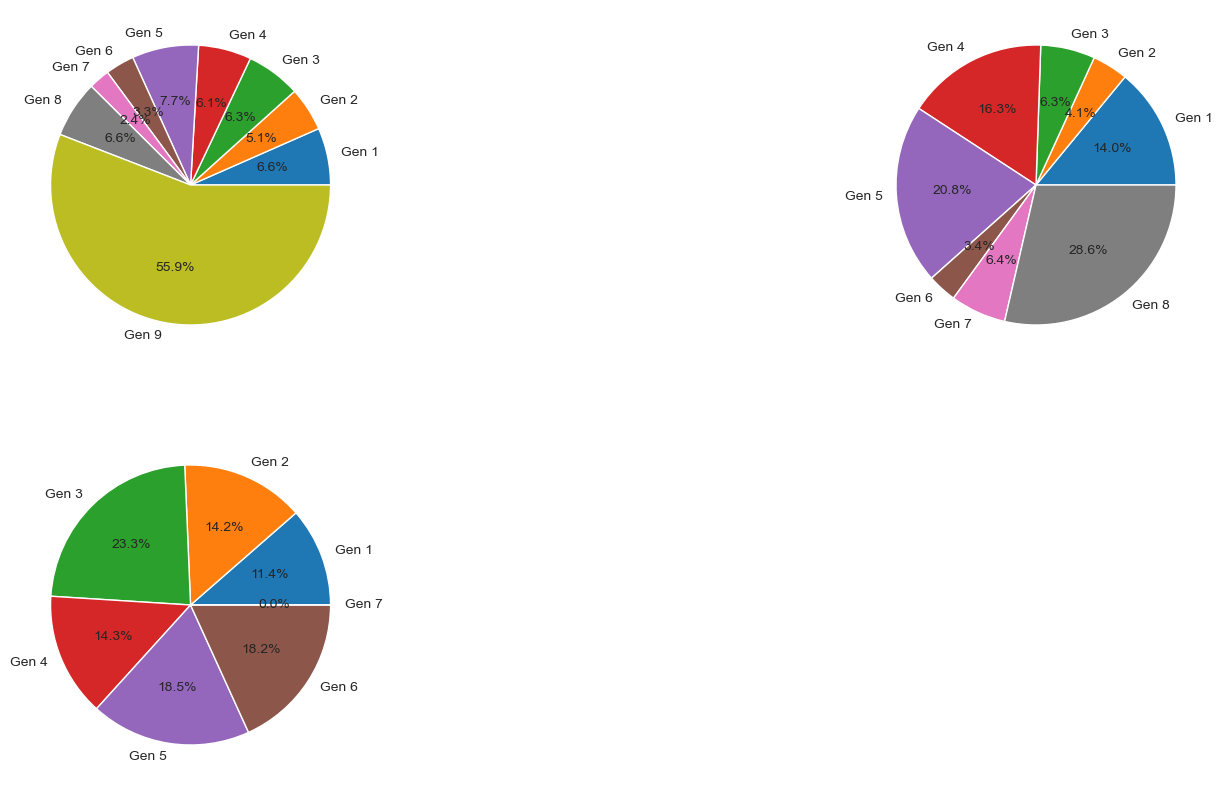

In [508]:
gen9_counts = []
for x in range(1, 10):
    gen9_counts.append(df_gen9.loc[df_gen9['generation'] == x, 'count'].sum())
print(gen9_counts)

gen8_counts = []
for x in range(1, 9):
    gen8_counts.append(df_gen8.loc[df_gen8['generation'] == x, 'count'].sum())
print(gen8_counts)

gen7_counts = []
for x in range(1, 8):
    gen7_counts.append(df_gen7.loc[df_gen7['generation'] == x, 'count'].sum())
print(gen7_counts)

plt.figure(figsize=[20, 10])

plt.subplot(2,2,1)
plt.pie(gen9_counts, labels=['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6', 'Gen 7', 'Gen 8','Gen 9'], autopct='%1.1f%%')

plt.subplot(2,2,2)
plt.pie(gen8_counts, labels=['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6', 'Gen 7', 'Gen 8'], autopct='%1.1f%%')

plt.subplot(2,2,3)
plt.pie(gen7_counts, labels=['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6', 'Gen 7'], autopct='%1.1f%%')

plt.show()

In [509]:
plot_data = df_gen9[['count', 'hp', 'atk', 'def', 'sp.atk', 'sp.def', 'spd']]

sns.pairplot(plot_data, hue="count")

ValueError: No variables found for grid columns.